In [1]:
!pip -q install xgboost


In [2]:
import io
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, classification_report, roc_auc_score, RocCurveDisplay
)
from xgboost import XGBClassifier


In [3]:
uploaded = files.upload()  # pick your CSV from local drive
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(df.shape, df.columns.tolist()[:10])


Saving updated_u2714523_DS7010_Credit.csv to updated_u2714523_DS7010_Credit.csv
(37382, 24) ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']


In [4]:
selected_columns = [
    "LIMIT_BAL", "SEX", "EDUCATION", "AGE",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    "default payment next month"
]
df = df[selected_columns].copy()

# (optional) basic sanity checks
assert "default payment next month" in df.columns, "Target column missing!"
print(df.isna().sum().sum(), "missing values total")


0 missing values total


In [5]:
X = df.drop("default payment next month", axis=1)
y = df["default payment next month"].astype(int)  # ensure 0/1 ints


In [6]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",   # fast & solid default
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

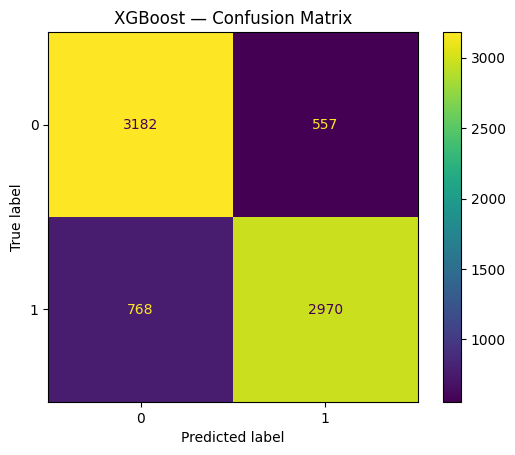

Accuracy: 0.8228
              precision    recall  f1-score   support

           0     0.8056    0.8510    0.8277      3739
           1     0.8421    0.7945    0.8176      3738

    accuracy                         0.8228      7477
   macro avg     0.8238    0.8228    0.8226      7477
weighted avg     0.8238    0.8228    0.8226      7477

ROC-AUC: 0.9022


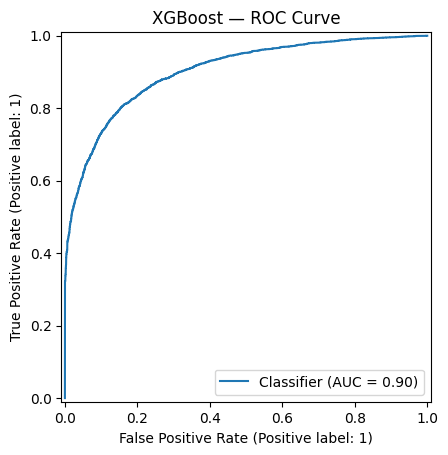

In [9]:
# Predictions
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("XGBoost — Confusion Matrix")
plt.show()

# Accuracy & classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, digits=4))

# ROC-AUC + curve
auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {auc:.4f}")
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("XGBoost — ROC Curve")
plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV


In [11]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}


In [12]:
xgb_model = XGBClassifier(
    tree_method="hist",  # fast & GPU-friendly if available
    random_state=42,
    eval_metric="logloss"
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1
)


In [13]:
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Best CV Accuracy: 0.8337065810915926


In [ ]:
best_xgb = grid_search.best_estimator_

y_pred_tuned = best_xgb.predict(X_test)
y_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Tuned XGBoost — Confusion Matrix")
plt.show()

# Accuracy, Classification Report & ROC-AUC
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(classification_report(y_test, y_pred_tuned, digits=4))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")


In [14]:
# Count positives (1) and negatives (0)
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos
print("Negatives:", neg, "Positives:", pos)
print("Scale_pos_weight:", scale_pos_weight)


Negatives: 14952 Positives: 14953
Scale_pos_weight: 0.9999331237878687


In [15]:
xgb_cost = XGBClassifier(
    n_estimators=grid_search.best_params_.get("n_estimators", 300),
    max_depth=grid_search.best_params_.get("max_depth", 5),
    learning_rate=grid_search.best_params_.get("learning_rate", 0.1),
    subsample=grid_search.best_params_.get("subsample", 0.8),
    colsample_bytree=grid_search.best_params_.get("colsample_bytree", 0.8),
    tree_method="hist",
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight   # key for cost-sensitive learning
)

xgb_cost.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

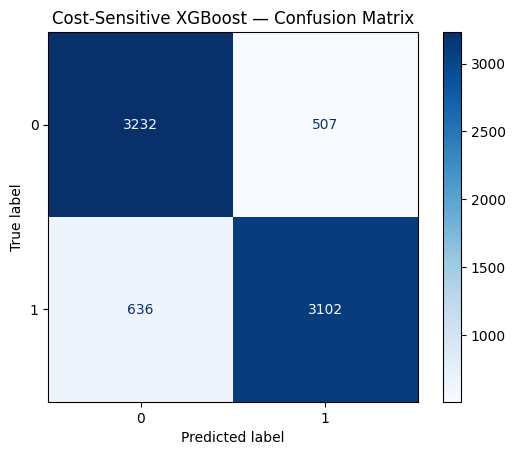

Test Accuracy: 0.8471
              precision    recall  f1-score   support

           0     0.8356    0.8644    0.8497      3739
           1     0.8595    0.8299    0.8444      3738

    accuracy                         0.8471      7477
   macro avg     0.8475    0.8471    0.8471      7477
weighted avg     0.8475    0.8471    0.8471      7477

Test ROC-AUC: 0.9240


In [16]:
y_pred_cost = xgb_cost.predict(X_test)
y_proba_cost = xgb_cost.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cost)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Cost-Sensitive XGBoost — Confusion Matrix")
plt.show()

# Accuracy, Report & ROC-AUC
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_cost):.4f}")
print(classification_report(y_test, y_pred_cost, digits=4))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba_cost):.4f}")


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_recall_fscore_support,
    classification_report, roc_auc_score, RocCurveDisplay, fbeta_score
)


In [18]:
selected_columns = [
    "LIMIT_BAL", "SEX", "EDUCATION", "AGE",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    "default payment next month"
]

# Use df_resampled if you created it; otherwise fall back to df
try:
    df_selected = df_resampled[selected_columns].copy()
except NameError:
    df_selected = df[selected_columns].copy()

X = df_selected.drop("default payment next month", axis=1)
y = df_selected["default payment next month"].astype(int)

print(X.shape, y.value_counts(normalize=True))


(37382, 22) default payment next month
0    0.5
1    0.5
Name: proportion, dtype: float64


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


In [20]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


In [21]:
def evaluate_and_collect(name, clf, X_te, y_te, proba_required=True, threshold=None):
    """
    proba_required: if True, use predict_proba for metrics like ROC-AUC.
    threshold: if provided (0-1), convert proba to class using custom threshold.
    """
    if proba_required:
        y_proba = clf.predict_proba(X_te)[:, 1]
        if threshold is None:
            y_pred = (y_proba >= 0.5).astype(int)
        else:
            y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = clf.predict(X_te)
        # if proba not available, make a pseudo-proba for auc (will skip)
        y_proba = None

    acc = accuracy_score(y_te, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)
    bal_pr, bal_rc, bal_f1, _ = precision_recall_fscore_support(y_te, y_pred, average="macro", zero_division=0)
    auc = roc_auc_score(y_te, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {pr:.4f} | Recall: {rc:.4f} | F1: {f1:.4f} | Macro-F1: {bal_f1:.4f} | ROC-AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_te, y_pred, digits=4))

    cm = confusion_matrix(y_te, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": pr,
        "Recall": rc,
        "F1": f1,
        "Macro-F1": bal_f1,
        "ROC-AUC": auc
    }



=== KNN — Baseline ===
Accuracy: 0.7462 | Precision: 0.7402 | Recall: 0.7584 | F1: 0.7492 | Macro-F1: 0.7461 | ROC-AUC: 0.8123

Classification Report:
              precision    recall  f1-score   support

           0     0.7524    0.7339    0.7430      3739
           1     0.7402    0.7584    0.7492      3738

    accuracy                         0.7462      7477
   macro avg     0.7463    0.7462    0.7461      7477
weighted avg     0.7463    0.7462    0.7461      7477



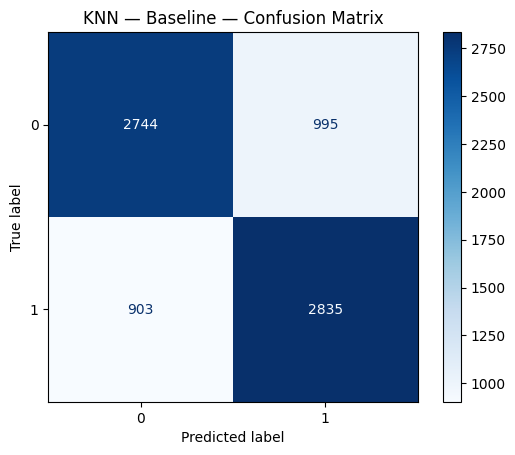

In [22]:
knn_base = KNeighborsClassifier(
    n_neighbors=5,      # baseline k
    weights="uniform",  # or "distance"
    p=2                 # Minkowski with p=2 → Euclidean
)
knn_base.fit(X_train_sc, y_train)

res_base = evaluate_and_collect("KNN — Baseline", knn_base, X_test_sc, y_test, proba_required=True)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params: {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
Best CV Balanced Accuracy: 0.7742849954545911

=== KNN — Grid Tuned ===
Accuracy: 0.7797 | Precision: 0.7656 | Recall: 0.8063 | F1: 0.7854 | Macro-F1: 0.7796 | ROC-AUC: 0.8622

Classification Report:
              precision    recall  f1-score   support

           0     0.7955    0.7531    0.7737      3739
           1     0.7656    0.8063    0.7854      3738

    accuracy                         0.7797      7477
   macro avg     0.7805    0.7797    0.7796      7477
weighted avg     0.7805    0.7797    0.7796      7477



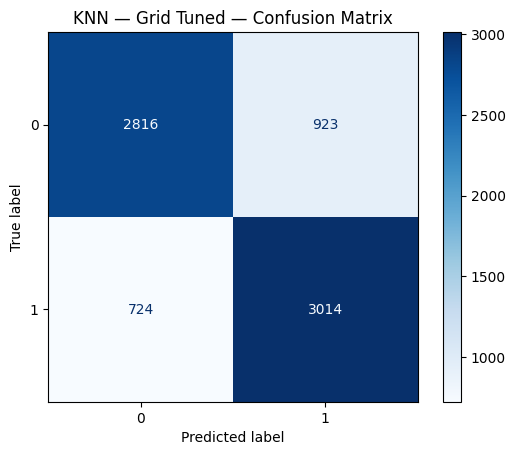

In [23]:
param_grid = {
    "n_neighbors": [3, 5, 7, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # Manhattan vs Euclidean
}

knn_for_grid = KNeighborsClassifier()
grid = GridSearchCV(
    estimator=knn_for_grid,
    param_grid=param_grid,
    scoring="balanced_accuracy",  # good when classes are imbalanced
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_sc, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Balanced Accuracy:", grid.best_score_)

knn_tuned = grid.best_estimator_
res_tuned = evaluate_and_collect("KNN — Grid Tuned", knn_tuned, X_test_sc, y_test, proba_required=True)


Best threshold (F2 on validation): 0.22

=== KNN — Cost-Sensitive (Threshold) ===
Accuracy: 0.6615 | Precision: 0.6019 | Recall: 0.9537 | F1: 0.7380 | Macro-F1: 0.6299 | ROC-AUC: 0.8622

Classification Report:
              precision    recall  f1-score   support

           0     0.8887    0.3694    0.5218      3739
           1     0.6019    0.9537    0.7380      3738

    accuracy                         0.6615      7477
   macro avg     0.7453    0.6615    0.6299      7477
weighted avg     0.7453    0.6615    0.6299      7477



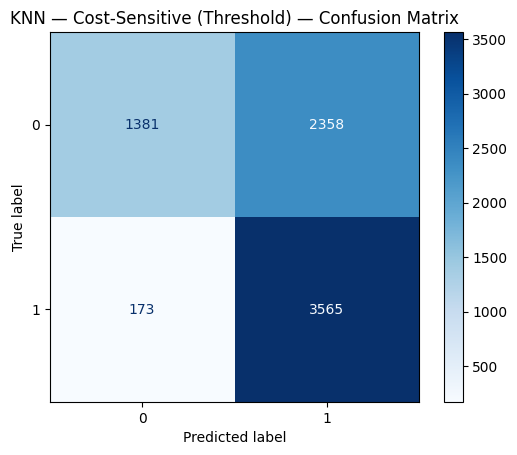

In [24]:
# Use the tuned model for best base behavior; you can also try knn_base
knn_cost = knn_tuned

# Get probabilities on validation (use training with CV or a holdout).
# Here, we'll pick threshold on the TRAIN set via internal split to avoid peeking at test.
X_tr, X_va, y_tr, y_va = train_test_split(
    X_train_sc, y_train, test_size=0.25, random_state=42, stratify=y_train
)

knn_cost.fit(X_tr, y_tr)
va_proba = knn_cost.predict_proba(X_va)[:, 1]

thresholds = np.linspace(0.10, 0.90, 81)
scores = []
for t in thresholds:
    preds_t = (va_proba >= t).astype(int)
    scores.append(fbeta_score(y_va, preds_t, beta=2, zero_division=0))

best_t = thresholds[int(np.argmax(scores))]
print(f"Best threshold (F2 on validation): {best_t:.2f}")

# Retrain on full train set and evaluate on test with the chosen threshold
knn_cost.fit(X_train_sc, y_train)
res_cost = evaluate_and_collect("KNN — Cost-Sensitive (Threshold)", knn_cost, X_test_sc, y_test, proba_required=True, threshold=best_t)


In [25]:
results_df = pd.DataFrame([res_base, res_tuned, res_cost])
results_df = results_df.sort_values(by=["Recall","F1","Accuracy"], ascending=False)
display(results_df)


,Model,Accuracy,Precision,Recall,F1,Macro-F1,ROC-AUC
2,KNN — Cost-Sensitive (Threshold),0.661495,0.601891,0.953719,0.738019,0.629920,0.862248
1,KNN — Grid Tuned,0.779724,0.765558,0.806314,0.785407,0.779570,0.862248
0,KNN — Baseline,0.746155,0.740209,0.758427,0.749207,0.746117,0.812276


<Figure size 600x500 with 0 Axes>

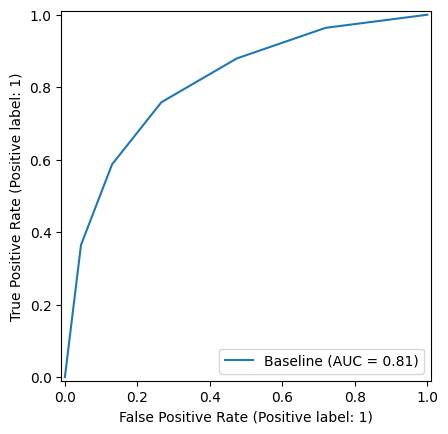

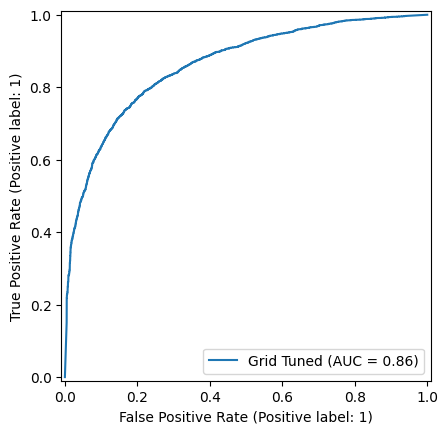

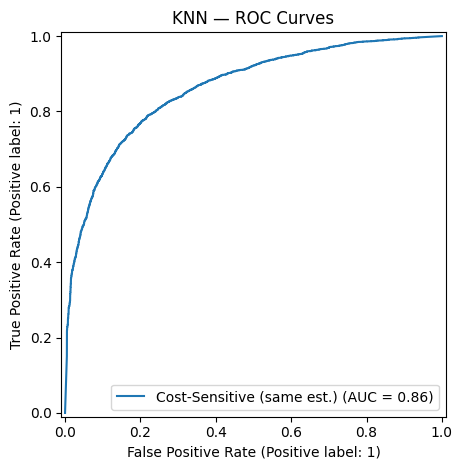

In [26]:
plt.figure(figsize=(6, 5))

# Baseline
RocCurveDisplay.from_estimator(knn_base, X_test_sc, y_test, name="Baseline")
# Tuned
RocCurveDisplay.from_estimator(knn_tuned, X_test_sc, y_test, name="Grid Tuned")
# Cost-sensitive uses threshold; ROC is threshold-invariant, so same curve as tuned model,
# but we still plot for reference using the same estimator:
RocCurveDisplay.from_estimator(knn_cost, X_test_sc, y_test, name="Cost-Sensitive (same est.)")

plt.title("KNN — ROC Curves")
plt.tight_layout()
plt.show()
